#  Differential abundance analysis

### 0. Setup

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway

%matplotlib inline

In [2]:
# location of the data and all the results produced by this notebook 
data_dir = 'project_data'


if not os.path.isdir(data_dir):
    os.makedirs(data_dir) 

# 1. Data import

In [6]:
#filtered sequence
! wget -nv -O $data_dir/rep-seqs.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza'

# Cleaned Feature Table
! wget -nv -O $data_dir/table.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza'

# Taxonomy file generate from silva
! wget -nv -O $data_dir/taxonomy_1.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza'

# Phylogeny file 
! wget -nv -O $data_dir/fasttree-tree-rooted.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza'

# Metadata
! wget -nv -O $data_dir/sample_metadata.tsv 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv'

2022-12-11 21:29:02 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza [390624/390624] -> "project_data/rep-seqs.qza" [1]
2022-12-11 21:29:03 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza [504534/504534] -> "project_data/table.qza" [1]
2022-12-11 21:29:03 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza [303165/303165] -> "project_data/taxonomy_1.qza" [1]
2022-12-11 21:29:03 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza [249852/249852] -> "project_data/fasttree-tree-rooted.qza" [1]
2022-12-11 21:29:04 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv [300302/300302] -> "project_data/sample_metadata.tsv" [1]


### Metadata

In [3]:
metadata_df = pd.read_csv(f'project_data/sample_metadata.tsv', sep='\t', index_col=0)
metadata_df.head()

,GEN_age_cat,GEN_age_corrected,GEN_bmi_cat,GEN_bmi_corrected,GEN_cat,GEN_collection_timestamp,GEN_country,GEN_dog,GEN_elevation,GEN_geo_loc_name,...,NUT_probiotic_frequency,NUT_red_meat_frequency,NUT_salted_snacks_frequency,NUT_seafood_frequency,NUT_sugary_sweets_frequency,NUT_vegetable_frequency,NUT_vitamin_b_supplement_frequency,NUT_vitamin_d_supplement_frequency,NUT_whole_eggs,NUT_whole_grain_frequency
sampleid,,,,,,,,,,,,,,,,,,,,,
10317.000046,20s,20.0,Normal,23.75,False,2016-08-25 18:30:00,USA,True,1919.3,USA:CO,...,Rarely,Regularly,Occasionally,Rarely,Occasionally,Occasionally,Never,Never,Daily,Daily
10317.000050,Not provided,NaN,Overweight,25.61,False,2016-07-06 09:00:00,United Kingdom,False,65.5,United Kingdom:England,...,Rarely,Rarely,Regularly,Occasionally,Regularly,Regularly,Never,Never,Rarely,Occasionally
10317.000038,30s,39.0,Overweight,27.67,False,2016-06-29 09:30:00,United Kingdom,False,44.5,United Kingdom:England,...,Never,Occasionally,Daily,Occasionally,Rarely,Occasionally,Never,Never,Regularly,Occasionally
10317.000047,50s,56.0,Normal,19.71,False,2016-07-12 17:30:00,Germany,False,8.7,Germany:HH,...,Daily,Occasionally,Rarely,Not provided,Rarely,Regularly,Daily,Daily,Rarely,Regularly
10317.000046,40s,45.0,Normal,23.15,False,2016-05-24 19:00:00,United Kingdom,True,68.8,United Kingdom:Unspecified,...,Regularly,Never,Never,Occasionally,Never,Daily,Rarely,Occasionally,Regularly,Daily


### Feature Table

In [5]:
data = q2.Artifact.load(f'{data_dir}/table.qza').view(pd.DataFrame)

In [6]:
data.head()

,d46e2205f0c6ecf67b51f83d111c509c,99deb3c5ecb022ec05609ebd1112a557,f5f5e0da89730462abaf6301a9557193,fd44d4cb468fd7dc9b3227867714ed87,945184b6386c192c0066e0a98a154780,59777186ad2e0947e97615b5d6225136,263e41ea2c25dc87bd2ff5910cf30d40,4d72007c70f4abc0bf9e8fe8b826d07d,675c847bccbc53942ebb7b8cbb4efc4d,b15193fce14759d1c06728933e044af6,...,507785cd038a4e0650f1844606f53ad1,c06962c02c12a6b0dd56cb66968d827e,ab8ebba691837ccf95875676c927469c,5e21e17b7c13cac116ba54cd3b845500,2312c3c203a8fd2790dad9758c619811,dc7a907070fd0d2fdbf8b6276cce63df,1bcc579a1539b94b47ce334f316858bf,e22361cd76edf4fd1c6b4d3c37de84a8,b609812bad30be7d797121140a222bc3,9acfceacf67f31dbde50e1c671a06b19
10317.000002929,0.0,1877.0,1082.0,0.0,0.0,134.0,1336.0,0.0,0.0,513.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000002930,0.0,179.0,86.0,212.0,19.0,233.0,275.0,0.0,2348.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000003283,4625.0,1875.0,305.0,0.0,0.0,482.0,43.0,0.0,49.0,392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000004079,6.0,1719.0,106.0,0.0,0.0,1981.0,0.0,0.0,0.0,350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000016169,600.0,395.0,534.0,0.0,0.0,181.0,192.0,0.0,22.0,312.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our Feature Table looks sparse and non normal. In the following this will be further investigated.

# 1. Check for data normality and sparsity

Before a statistical test is applied to investigate differential abundance, the data is closely examined. In order to select a suitable statistical test, both data structure and sparsity must be examined.

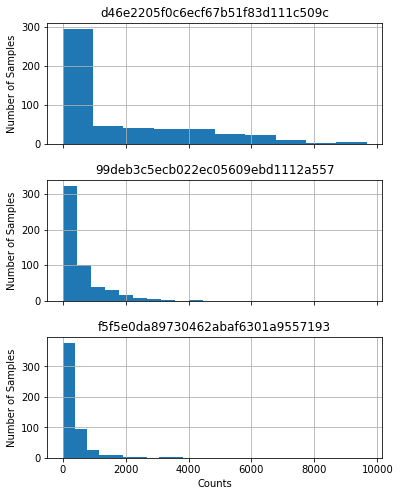

In [7]:
I = data.sum()[0:3].index
most_abuns = data[I]
h = most_abuns.hist(layout=(3,1), figsize=(6, 8), sharex=True)
plt.xlabel('Counts')
h = [ax[0].set_ylabel('Number of Samples') for ax in h]


After plotting the 3 most abundant ASV, it is cleat that the ASV's are not normal distributed!
Let's look at the violin plot to check for sparsity of our data. For this we reshuffle the data and randomly choose 20 examples out of the data. 

In [8]:
n = 20

# draw n ASVs out of the original DataFrame
data_samp = data.sample(n=n, axis=1, random_state=1414)

# create a new DataFrame with three columns (sample, ASV, abundance)
col_names = {'level_0': 'sample', 'level_1': 'asv', 0: 'count'}
data_plot = data_samp.stack().reset_index().rename(columns=col_names)

# make sure the shape is correct (no. of rows should be equal to the size of our random 
# sample multiplied by number of samples)
assert data_plot.shape[0] == n * data_samp.shape[0], 'The new DataFrame has an incorrect no. of rows.'
data_plot.head()

,sample,asv,count
0,10317.000002929,72843ab08016c07e44b3f7a148157ffc,0.0
1,10317.000002929,d53e2ad7162860b80a16b636ab59a039,0.0
2,10317.000002929,7759604db6eb1f89e430cab74dcbc5df,0.0
3,10317.000002929,a09ceaed5bdfdef2d6ee2b723513e355,0.0
4,10317.000002929,a28399a8ab7348fdce49e6dbc01348a0,0.0


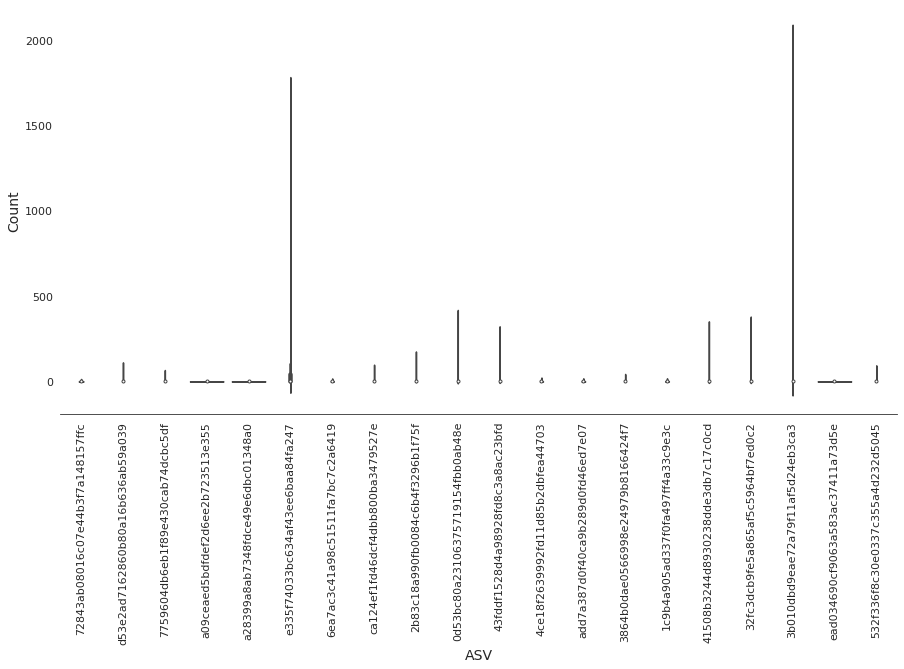

In [9]:
with sns.axes_style('white'), sns.color_palette('Set1'):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7.5)
    
    sns.violinplot(data=data_plot, x='asv', y='count', ax=ax)
    sns.despine(left=True)
    
    # adjust tick labels and axes titles
    ax.tick_params(axis='x', rotation=90, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_xlabel('ASV', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

Almost all of the randomly choosen ASV have thir mean at 0. Thus, our data is sparse.
To quantitativle prove that our data is most likely not normal distributed we perform the Shapiro-Wilk test for normality. 
The Shapiro-Wilk test assumes the null-hypothesis that the data is normally distributed. Resulting in rejection of this hypothesis if the p-value is <0.05. This means that a p-value on <0.05 suggests that the data is not normaly distributed.

In [10]:
alpha = 0.05
results = {}

# iterate through rows (samples) and test each of them for normality
for asv_name, asv_values in data.iteritems():
    stat, p = shapiro(asv_values)
    results[asv_name] = p

# convert test results into a DataFrame
results_df = pd.DataFrame(data=results.values(), index=results.keys(), columns=['p'])

# add a new column with a descriptive test result
results_df['is_normal'] = results_df['p'] > alpha
print('Number of ASVs with normal distribution:', results_df['is_normal'].sum())

Number of ASVs with normal distribution: 0


The test now finally revealed that our data is not gaussian distributed. This means that normal tests for differential abundance such as ANOVA can not be applied to the data as they would result in misleading test results. To avoid this we choose ANCOM statistics (Analysis of composition of microbiomes) which is specifically developed for this data type we encounter here. 
ANCOM takes into account the underlying data structure and can be used to compare the composition of microbiomes in two or more samples. ANCOM makes no distributional assumptions and can be implemented in a linear model framework to account for covariates. ANCOM also easily can be scaled up to compare samples with thousands of taxa. (https://pubmed.ncbi.nlm.nih.gov/26028277/)

# 1. ANCOM

To improve the resolution and limit the FDR (false discovery rate), one filters the feature table to ASVs that have a frequency of at least 25 and occur in at least 5 samples. Features that do not occur frequently could be caused by noise in the data and would thus increase the FDR penalty. ANCOM cannot tolerate 0 as an ASV frequency because the method uses a log transformation or log ratio. Since the log of 0 is not defined, one must take this into account. To get around this obstacle, one can insert a pseudo-count into the frequency table. The result is a table in the format `FeatureTable[Composition]`.

### 1.1 Frequency filtering

In [11]:
! qiime feature-table filter-features \
    --i-table $data_dir/table.qza \
    --p-min-frequency 25 \
    --p-min-samples 5 \
    --o-filtered-table $data_dir/table_abund.qza

Saved FeatureTable[Frequency] to: project_data/table_abund.qza


In [12]:
abund_data = q2.Artifact.load(f'{data_dir}/table_abund.qza').view(pd.DataFrame)
abund_data.head(5)

,d46e2205f0c6ecf67b51f83d111c509c,99deb3c5ecb022ec05609ebd1112a557,f5f5e0da89730462abaf6301a9557193,fd44d4cb468fd7dc9b3227867714ed87,945184b6386c192c0066e0a98a154780,59777186ad2e0947e97615b5d6225136,263e41ea2c25dc87bd2ff5910cf30d40,4d72007c70f4abc0bf9e8fe8b826d07d,675c847bccbc53942ebb7b8cbb4efc4d,b15193fce14759d1c06728933e044af6,...,6e129c93672f058c66c7090dbf93dbdf,9e0326554068ca2dfdaf5f8ab043fea8,422443b7e46f6631c5a7cc89316be0d0,5a995ef0ef454381562fe4d6909fa8d4,da3d66136d172ba73195d7c6629399df,70c0d497b59c83efba188e9cf1a99902,5443a3f15cad4117ecbc72bfd4de8f25,2dbaf07cdc2dece27cda9675d3850efe,b6ed1fda48450bc73938e1aad922a581,b22201b7fed31c775a16f6e9a498903e
10317.000002929,0.0,1877.0,1082.0,0.0,0.0,134.0,1336.0,0.0,0.0,513.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000002930,0.0,179.0,86.0,212.0,19.0,233.0,275.0,0.0,2348.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000003283,4625.0,1875.0,305.0,0.0,0.0,482.0,43.0,0.0,49.0,392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000004079,6.0,1719.0,106.0,0.0,0.0,1981.0,0.0,0.0,0.0,350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000016169,600.0,395.0,534.0,0.0,0.0,181.0,192.0,0.0,22.0,312.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Form the initial 5066 ASV's only 951 are left after this filtering step.

### 1.2 Inserting pseudo-count

In [13]:
! qiime composition add-pseudocount \
    --i-table $data_dir/table_abund.qza \
    --o-composition-table $data_dir/pseud_table_abund.qza

Saved FeatureTable[Composition] to: project_data/pseud_table_abund.qza


In [14]:
abund_data = q2.Artifact.load(f'{data_dir}/pseud_table_abund.qza').view(pd.DataFrame)
0 in abund_data

False

The data does not contain any zeros anymore.

### 1.3 ANCOM: Analysis

The categories form Alpha and beta diversity analysis which showed significance in addition to the different defined meal types were choosen to further investigate with the ANCOM analysis.

In [22]:
# location of the data and all the results produced by this notebook 
ANCOM_Res = 'project_data/ANCOM_results'


if not os.path.isdir(ANCOM_Res):
    os.makedirs(ANCOM_Res) 

In [58]:
metadata_df.columns.tolist()

['GEN_age_cat',
 'GEN_age_corrected',
 'GEN_bmi_cat',
 'GEN_bmi_corrected',
 'GEN_cat',
 'GEN_collection_timestamp',
 'GEN_country',
 'GEN_dog',
 'GEN_elevation',
 'GEN_geo_loc_name',
 'GEN_height_cm',
 'GEN_host_common_name',
 'GEN_last_move',
 'GEN_last_travel',
 'GEN_latitude',
 'GEN_level_of_education',
 'GEN_longitude',
 'GEN_race',
 'GEN_sample_type',
 'GEN_sex',
 'GEN_weight_kg',
 'NUT_alcohol_consumption',
 'NUT_alcohol_frequency',
 'NUT_alcohol_types_beercider',
 'NUT_alcohol_types_red_wine',
 'NUT_alcohol_types_sour_beers',
 'NUT_alcohol_types_spiritshard_alcohol',
 'NUT_alcohol_types_unspecified',
 'NUT_alcohol_types_white_wine',
 'NUT_artificial_sweeteners',
 'NUT_diet_type',
 'NUT_drinks_per_session',
 'NUT_fed_as_infant',
 'NUT_fermented_plant_frequency',
 'NUT_frozen_dessert_frequency',
 'NUT_fruit_frequency',
 'NUT_gluten',
 'NUT_high_fat_red_meat_frequency',
 'NUT_homecooked_meals_frequency',
 'NUT_lowgrain_diet_type',
 'NUT_meat_eggs_frequency',
 'NUT_milk_cheese_freq

In [15]:
pd.DataFrame([str(sorted(metadata_df[col].astype(str).unique())) for col in metadata_df.columns],
             index=pd.Index(metadata_df.columns, name='Column'), columns=['Values'])

,Values
Column,
GEN_age_cat,"['20s', '30s', '40s', '50s', '60s', '70+', 'No..."
GEN_age_corrected,"['11.0', '14.0', '15.0', '16.0', '17.0', '18.0..."
GEN_bmi_cat,"['Normal', 'Not provided', 'Obese', 'Overweigh..."
GEN_bmi_corrected,"['11.2', '11.57', '14.34', '14.62', '14.79', '..."
GEN_cat,"['False', 'True']"
GEN_collection_timestamp,"['2014-05-10 12:00:00', '2015-01-01 09:00:00',..."
GEN_country,"['Australia', 'Belgium', 'Canada', 'Georgia', ..."
GEN_dog,"['False', 'True']"
GEN_elevation,"['-0.9', '0.0', '1.4', '10.4', '10.8', '10.9',..."


In [1]:
! qiime composition ancom --help

Usage: qiime composition ancom [OPTIONS]

  Apply Analysis of Composition of Microbiomes (ANCOM) to identify features
  that are differentially abundant across groups.

Inputs:
  --i-table ARTIFACT FeatureTable[Composition]
                       The feature table to be used for ANCOM computation.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]
                       The categorical sample metadata column to test for
                       differential abundance across.               [required]
  --p-transform-function TEXT Choices('sqrt', 'log', 'clr')
                       The method applied to transform feature values before
                       generating volcano plots.              [default: 'clr']
  --p-difference-function TEXT Choices('mean_difference', 'f_statistic')
                       The method applied to visualize fold difference in
       

Transformation methods:  --p-transform-function TEXT Choices('sqrt', 'log', 'clr')

### Check for differential abundance in the alcohol consumption category -- log transormation

In [20]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_consumption \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_consumption.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_consumption.qzv


In [4]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_consumption.qzv')

<visualization: Visualization uuid: 55fc20e2-e9a7-44f3-a1d8-0a508adbc914>

differential ASV's: (top 3)

dcba105f35d8ebc9e22269c7491ad3a7 --> k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas; s__geniculata --> Conf: 0.7288359940778949

ec6732c2e0d4cf64b3d0350e7fe3defb --> k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Roseburia; s__inulinivorans --> Conf: 0.7465821860521127

5a6c87d6a4eb5e114959f6192f29b641 --> k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium; s__adolescentis --> Conf: 0.9143623365632302

### Check for differential abundance in the alcohol consumption category -- crl transformation

In [26]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_consumption \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_consumption-transform.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_consumption-transform.qzv


In [27]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_consumption-transform.qzv')

<visualization: Visualization uuid: a5bdcaf5-49fe-48e0-bce3-ccdfd9d7feab>

### Check for differential abundance in the alcohol consumption category -- sqrt transformation

In [28]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_consumption \
    --p-transform-function sqrt \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_consumption-sqrt.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_consumption-sqrt.qzv


In [3]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_consumption-sqrt.qzv')

<visualization: Visualization uuid: 5eb11e4f-fbd5-4ea9-b5aa-706c6c32bbdf>

As the different transformations do not drastically change the Volcano plot, we choose to stick with the log-transformation for the following analysis.

### Check for differntial abundance in NUT_alcohol_frequency

In [23]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_frequency.qzv


In [11]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_frequency.qzv')

<visualization: Visualization uuid: a9e16a45-4f4a-440d-b621-0266daff73ce>

differential ASV's:

d1b9cd324ba837bb9f2e780dc1116882 --> k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Christensenellaceae; g__; s__ --> Conf: 0.9999435810436742

### Check for differntial abundance in NUT_alcohol_types_red_wine

In [30]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_types_red_wine \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_types_red_wine.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_types_red_wine.qzv


In [6]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_types_red_wine.qzv')

<visualization: Visualization uuid: ac05947a-5214-4f35-8410-09782b5bf68e>

differential ASV's: none

### Check for differntial abundance in NUT_alcohol_types_unspecified

In [32]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_alcohol_types_unspecified \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_alcohol_types_unspecified.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_alcohol_types_unspecified.qzv


In [7]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_alcohol_types_unspecified.qzv')

<visualization: Visualization uuid: 18d206c3-f4be-403f-b44a-9ede5dd2ba29>

differential ASV's: none

### Check for differntial abundance in NUT_olive_oil

In [34]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_olive_oil \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_olive_oil.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_olive_oil.qzv


In [25]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_olive_oil.qzv')

<visualization: Visualization uuid: 4bc6b7a5-e966-4897-b60f-8ba906494869>

differential ASV's:

ed8746a919274371bea412882a1c6bb5 --> k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Dorea; s__ --> Conf: 0.9623306197472182

### Check for differntial abundance in NUT_prepared_meals_frequency

In [16]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_prepared_meals_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_prepared_meals_frequency.qzv

^C

Aborted!


In [9]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_prepared_meals_frequency.qzv')

<visualization: Visualization uuid: 27f8ff6c-4556-4e63-bcbb-ebfdb367661b>

differential ASV's:

ed8746a919274371bea412882a1c6bb5

### Check for differntial abundance in NUT_salted_snacks_frequency

In [38]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_salted_snacks_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_salted_snacks_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_salted_snacks_frequency.qzv


In [10]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_salted_snacks_frequency.qzv')

<visualization: Visualization uuid: d70a59e5-6c7f-4c64-8c9b-2e52d6ccfb2c>

differential ASV's:

ed8746a919274371bea412882a1c6bb5

### Check for differntial abundance in NUT_vegetable_frequency

In [40]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_vegetable_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_vegetable_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_vegetable_frequency.qzv


In [13]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_vegetable_frequency.qzv')

<visualization: Visualization uuid: 1f31d82d-0671-4ab1-9636-13b5f6996dfd>

differential ASV's:

c66ec67719e54d2cb0afc3154b3c23af --> k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__ --> Conf: 0.9998984336568779

96cf4779be686036f92ee15e58b72d52 --> k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Phascolarctobacterium; s__ --> Conf: 0.9999997694577

# Check for differential abundance in significant variables in beta diversity

### Check for differntial abundance in NUT_lowgrain_diet_type

In [4]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_lowgrain_diet_type \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_lowgrain_diet_type.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_lowgrain_diet_type.qzv


In [5]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_lowgrain_diet_type.qzv')

<visualization: Visualization uuid: dd6aca2a-3b4e-4017-9945-c8615fe398a9>

Differental ASV: 5a6c87d6a4eb5e114959f6192f29b641 most abundant in False

### Check for differntial abundance in NUT_probiotic_frequency

In [6]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_probiotic_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_probiotic_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_probiotic_frequency.qzv


In [7]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_probiotic_frequency.qzv')

<visualization: Visualization uuid: b87368b3-aaa1-400c-8179-1cadb4500989>

# Taxonomy

Differerential ASV: 6420671c26eef32065e0275c8cd6701e most abundant in never

### indentify taxonomy of differential ASV's

In [3]:
! qiime metadata tabulate \
    --m-input-file $data_dir/taxonomy_1.qza \
    --o-visualization $data_dir/taxonomy_1.qzv

Saved Visualization to: project_data/taxonomy_1.qzv


In [4]:
Visualization.load(f'{data_dir}/taxonomy_1.qzv')

<visualization: Visualization uuid: 007e6139-4228-446d-9d21-9f28b15f9e8d>

# Check for differential abundance in different diet types

## Milk Products

### Check for differntial abundance in NUT_milk_cheese_frequency

In [7]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_milk_cheese_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_milk_cheese_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_milk_cheese_frequency.qzv


In [8]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_milk_cheese_frequency.qzv')

<visualization: Visualization uuid: 34a0af94-e3b3-4ef6-9f21-42b3fa5ef6f8>

### Check for differntial abundance inNUT_milk_substitute_frequency

In [9]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_milk_substitute_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_milk_substitute_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_milk_substitute_frequency.qzv


In [10]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_milk_substitute_frequency.qzv')

<visualization: Visualization uuid: cd0b797c-3b3f-4e48-b4e4-6506ed1c3cc6>

### Check for differntial abundance in NUT_vitamin_d_supplement_frequency

In [11]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_vitamin_d_supplement_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_vitamin_d_supplement_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_vitamin_d_supplement_frequency.qzv


In [12]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_vitamin_d_supplement_frequency.qzv')

<visualization: Visualization uuid: 76df5bf5-db35-4140-be8f-80556391113d>

## Mediteranian

### Check for differntial abundance in NUT_whole_grain_frequency

In [13]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_whole_grain_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_whole_grain_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_whole_grain_frequency.qzv


In [14]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_whole_grain_frequency.qzv')

<visualization: Visualization uuid: fd7e8cd1-e56b-4c65-8a5d-d811a4e5ad7f>

### Check for differntial abundance in NUT_seafood_frequency

In [26]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_seafood_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_seafood_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_seafood_frequency.qzv


In [27]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_seafood_frequency.qzv')

<visualization: Visualization uuid: f4a91373-baa6-4f9c-b006-3e1b4d4363d2>

### Check for differntial abundance in fruit

In [15]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_fruit_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_fruit_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_fruit_frequency.qzv


In [16]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_fruit_frequency.qzv')

<visualization: Visualization uuid: ef31b684-03e9-48a6-8b9c-19857629e29c>

## Meat

### Check for differntial abundance in NUT_poultry_frequency

In [19]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_poultry_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_poultry_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_poultry_frequency.qzv


In [20]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_poultry_frequency.qzv')

<visualization: Visualization uuid: 981da2ea-f67e-41a5-9ebe-8a19949277be>

### Check for differntial abundance in high fat red meat

In [17]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_high_fat_red_meat_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_high_fat_red_meat_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_high_fat_red_meat_frequency.qzv


In [18]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_high_fat_red_meat_frequency.qzv')

<visualization: Visualization uuid: 0724e678-9231-4b50-a756-a14400b52612>

### Check for differntial abundance in NUT_red_meat_frequency

In [21]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_red_meat_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_red_meat_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_red_meat_frequency.qzv


In [22]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_red_meat_frequency.qzv')

<visualization: Visualization uuid: e32c2b4f-3ad5-4c69-bb70-1b5e50ad4461>

### Check for differntial abundance in NUT_vitamin_b_supplement_frequency

In [23]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_vitamin_b_supplement_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_vitamin_b_supplement_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_vitamin_b_supplement_frequency.qzv


In [24]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_vitamin_b_supplement_frequency.qzv')

<visualization: Visualization uuid: 6f2141de-b823-4c20-8edc-08f71f428267>

### Check for differntial abundance in NUT_meat_eggs_frequency

In [28]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_meat_eggs_frequency \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_meat_eggs_frequency.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_meat_eggs_frequency.qzv


In [29]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_meat_eggs_frequency.qzv')

<visualization: Visualization uuid: 9e8dfa56-7922-4d56-a1a8-06c7c9c51875>

### Check for differntial abundance in NUT_diet_type

In [5]:
! qiime composition ancom \
    --i-table $data_dir/pseud_table_abund.qza \
    --m-metadata-file $data_dir/sample_metadata.tsv \
    --m-metadata-column NUT_diet_type \
    --p-transform-function log \
    --o-visualization $data_dir/ANCOM_results/ancom_NUT_diet_type.qzv

Saved Visualization to: project_data/ANCOM_results/ancom_NUT_diet_type.qzv


In [6]:
Visualization.load(f'{data_dir}/ANCOM_results/ancom_NUT_diet_type.qzv')

<visualization: Visualization uuid: 804e918e-db90-4a06-a95d-ebfe53d3e416>